# Importing necessary libraries

Pandas and Numpy: For data manipulation and numerical computations.

Scikit-learn: For preprocessing, model building, evaluation, and hyperparameter tuning.

Matplotlib, Seaborn, and NetworkX: For data visualization and network analysis. This sets the foundation for your work, enabling operations on both structured and graphical data.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
#from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.preprocessing import TransactionEncoder

# After webscrapping the data we did data cleaning , preprocesssing and reduction .Then,we downloaded the data in same milestone for futhrer modeling pruporse i.e milestone3

# The dataset (Wikipediaclickstreamdata.csv) is loaded using Pandas:

we dropped an unnecessary column (z_score), which likely has no relevance to your analysis. it may clutter the data.


In [ ]:
# Loading data into pandas dataframe.
df = pd.read_csv('Wikipediaclickstreamdata.csv')
df = df.drop('z_score', axis=1)
df.head()

,prev,curr,type,n
0,other-empty,Liberty_Billings,external,13.0
1,other-empty,Liberty_Classical_Academy,external,13.0
2,other-empty,Liberty_County_Jail,external,13.0
3,other-empty,"Liberty_Downtown_Historic_District_(Liberty,_N...",external,13.0
4,other-empty,Liberty_Elementary_School_District,external,13.0


# Data exploration
It reveals the general characteristics of the dataset, giving clues about preprocessing needs.

describe() and info(): These provide summary statistics (mean, median, count, etc.) and data types.

It helps to understand the numerical variables and identify missing or irregular data types.

Sampling: You select a small fraction (10%) of the data for testing, reducing computational overhead.


In [ ]:
## exploring data to find out numerical metrices and datatypes.
df.describe()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999749 entries, 0 to 999748
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   prev    999749 non-null  object 
 1   curr    999744 non-null  object 
 2   type    999749 non-null  object 
 3   n       999749 non-null  float64
dtypes: float64(1), object(3)
memory usage: 30.5+ MB


df_chunk is a smaller subset of the original dataset (first quarter).
A 10% sample of df_chunk is selected to reduce the data size for quicker analysis.

In [ ]:
df_chunk = df.iloc[:len(df)//4]
print("Total number of rows:", len(df_chunk))
print("Total number of columns:", len(df_chunk.columns))
print("Size of the dataframe (rows x columns):", df_chunk.shape)

Total number of rows: 249937
Total number of columns: 4
Size of the dataframe (rows x columns): (249937, 4)


In [ ]:
df2=df_chunk.sample(frac=0.1)
len(df2)

24994

we found out unique values in the prev, curr, n, and type columns, which likely represent categorical data related to Wikipedia article interactions. By checking unique values, we can identify the categories within each feature, which helps in preparing the data for encoding or further analysis.


In [ ]:
print(df['prev'].unique())

['other-empty' 'other-search' 'One_Direction' ... 'Cherry_barb'
 'Cherry_blossom' 'Cherry_bomb_(disambiguation)']


In [ ]:
print(df['curr'].unique())

['Liberty_Billings' 'Liberty_Classical_Academy' 'Liberty_County_Jail' ...
 'ONIC_Philippines' 'Glasspack' 'Ollie_(skateboarding)']


In [ ]:
print(df['n'].unique())

[1.30000e+01 3.74900e+05 3.74171e+05 ... 1.75600e+03 1.75500e+03
 1.75400e+03]


In [ ]:
print(df['type'].unique())

['external' 'link' 'other']


# Finding frequent itemsets using Apriori or FP-growth

It is revealing patterns in Wikipedia article transitions.

Converting the dataset into transactions (pairs of prev and curr columns).this w is likely for performing frequent pattern mining.(e.g., finding common patterns between the articles visited by users).By converting the data into a transaction format.



In [ ]:
def find_frequent_patterns(df2):
  # Convert the dataframe into a list of transactions
  transactions = []
  for _, row in df2.iterrows():
    transactions.append(list(row.astype(str)))

  # Initialize the transaction encoder
  te = TransactionEncoder()
  te_ary = te.fit(transactions).transform(transactions)
  df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

  # Apply FP-growth algorithm
  frequent_itemsets = fpgrowth(df_encoded, min_support=0.05, use_colnames=True)

  return frequent_itemsets

# Call the function with your df_chunk
frequent_itemsets_result = find_frequent_patterns(df2)

# Print frequent itemsets
print(frequent_itemsets_result)

     support                          itemsets
0   0.908538                        (external)
1   0.498480                            (13.0)
2   0.097944                  (other-internal)
3   0.384652                     (other-empty)
4   0.333120                    (other-search)
5   0.091302                  (other-external)
6   0.088941                            (link)
7   0.498480                  (13.0, external)
8   0.097944        (other-internal, external)
9   0.094303            (other-internal, 13.0)
10  0.094303  (other-internal, 13.0, external)
11  0.384652           (external, other-empty)
12  0.313955               (13.0, other-empty)
13  0.313955     (13.0, external, other-empty)
14  0.333120          (other-search, external)
15  0.091302        (other-external, external)
16  0.090222            (other-external, 13.0)
17  0.090222  (other-external, 13.0, external)


High Support Itemsets: "external" and "13.0" have the highest support, which means these items are most commonly appearing in the transactions.

Co-occurring Itemsets: Itemsets like "(13.0, external)" and "(13.0, other-empty)" show that "13.0" frequently co-occurs with other items such as "external" and "other-empty".

Low Support Itemsets: Itemsets like "(link)", "(other-external)", and combinations including them show lower support, indicating these combinations appear less frequently in the dataset.

# Transition Probabilities

Calculating the transition probabilities between articles (prev to curr).

By determining the probability of transitions, you can analyze the flow of Wikipedia user behavior—how likely users are to move
from one article to another.

This is a common technique in predictive modeling and recommendation systems.

In [ ]:
import pandas as pd
# Compute transition probabilities
transition_counts = df.groupby(['prev', 'curr']).size().reset_index(name='count')
total_counts = transition_counts.groupby('prev')['count'].transform('sum')
transition_counts['probability'] = transition_counts['count'] / total_counts

# Check if the current_state exists
current_state = 'other-empty'
if current_state not in df['prev'].unique():
    print(f"'{current_state}' not found in 'prev' column. Available states are: {df['prev'].unique()}")
else:
    # Predict the next state given a current state
    predicted_next = transition_counts[transition_counts['prev'] == current_state].sort_values(by='probability', ascending=False)
    print(predicted_next)


               prev                  curr  count  probability
386672  other-empty                    %s      1     0.000006
494818  other-empty           Salil_Desai      1     0.000006
494811  other-empty   Salfords_and_Sidlow      1     0.000006
494812  other-empty      Sali_Tagliamonte      1     0.000006
494813  other-empty        Salicylic_acid      1     0.000006
...             ...                   ...    ...          ...
440745  other-empty    Magical_Connection      1     0.000006
440746  other-empty       Magical_Mystery      1     0.000006
440747  other-empty  Magical_Mystery_Tour      1     0.000006
440748  other-empty         Magical_Negro      1     0.000006
548887  other-empty                    🙏🏽      1     0.000006

[162216 rows x 4 columns]


the above emntioned transitions has lower probabilities
the whole data consits of low to high

# dividing training and testing data and preprocessing
Converting categorical data (prev column) into numeric labels.
    
Standard Scaling: Normalizes numerical data (n column) to a standard scale #(mean=0, std=1), which is essential for many machine learning models.

Encoding transforms non-numeric data into numeric format, and scaling ensures all features contribute equally to the model, preventing bias toward larger-scale features.the, Split the dataset into training (80%) and testing (20%) subsets. X #contains features, and y is the target variable i.e. type.This scales the 'n' column (presumably a numeric feature) so that it has a mean of 0 and a standard deviation of 1.

StandardScaler(): Standardizes the data by removing the mean and scaling to unit variance, which is particularly important when using models like neural networks.

fit_transform(): Fits the scaler to the 'n' column and then applies the scaling transformation.

In [ ]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

label_encoders = {}
for col in ['prev', 'curr', 'type']:  # Replace with your actual categorical columns
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# Scaling numeric columns
scaler = StandardScaler()
df['n'] = scaler.fit_transform(df[['n']])  # Scaling 'n', assuming it's numeric

# Train-test split
X = df.drop(columns=['type'])  # 'type' is the target column
y = df['type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check shapes after split
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Ensure class balance (optional but useful for imbalanced classes)
print(f"Class distribution in y_train:\n{y_train.value_counts()}")
print(f"Class distribution in y_test:\n{y_test.value_counts()}")

# Define confusion matrix plot function
def plot_confusion_matrix(cm, title, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()


X_train shape: (799799, 3)
X_test shape: (199950, 3)
y_train shape: (799799,)
y_test shape: (199950,)
Class distribution in y_train:
type
0    488897
1    302544
2      8358
Name: count, dtype: int64
Class distribution in y_test:
type
0    122253
1     75612
2      2085
Name: count, dtype: int64


Checking training and testing data
# Training a Logistic Regression model to predict the type of article transitions.
Testing trained model against test dataset.

In [ ]:
# Check the split results
print("X_train shape:", X_train.shape)  # (799799, 3)
print("X_test shape:", X_test.shape)    # (199950, 3)
print("y_train shape:", y_train.shape)  # (799799,)
print("y_test shape:", y_test.shape)    # (199950,)

# Train the logistic regression model
logistic_model = LogisticRegression(max_iter=500, class_weight="balanced", random_state=42)
logistic_model.fit(X_train, y_train)

# Make predictions
y_pred_logistic = logistic_model.predict(X_test)

# Check the predictions' shape
print("y_pred_logistic shape:", y_pred_logistic.shape)  # Should be (199950,)

# Now proceed with evaluation


X_train shape: (799799, 3)
X_test shape: (199950, 3)
y_train shape: (799799,)
y_test shape: (199950,)
y_pred_logistic shape: (199950,)


evaluating the performance of the Logistic Regression
then, Generated a classification report that includes detailed performance metrics like precision, recall, and F1-score for each class.

---- Logistic Regression (Balanced Class Weights) ----
Accuracy: 0.763675918979745
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    122253
           1       0.98      0.38      0.55     75612
           2       0.03      0.69      0.06      2085

    accuracy                           0.76    199950
   macro avg       0.67      0.69      0.53    199950
weighted avg       0.97      0.76      0.82    199950



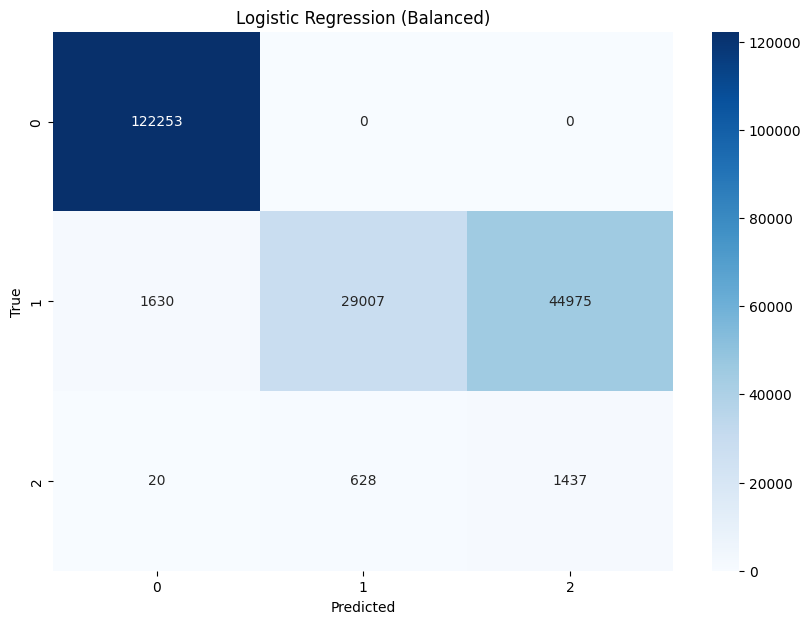

y_pred_logistic shape: (199950,)


In [ ]:
# Evaluation
logistic_acc = accuracy_score(y_test, y_pred_logistic)
logistic_report = classification_report(y_test, y_pred_logistic, zero_division=1)  # Set undefined precision/recall to 1
logistic_cm = confusion_matrix(y_test, y_pred_logistic)

print("---- Logistic Regression (Balanced Class Weights) ----")
print("Accuracy:", logistic_acc)
print("Classification Report:\n", logistic_report)

class_names = sorted(y_test.unique())
plot_confusion_matrix(logistic_cm, "Logistic Regression (Balanced)", class_names)
print("y_pred_logistic shape:", y_pred_logistic.shape)


findings:It yields an accuracy of 76.36%, meaning that it correctly predicts the class for approximately 76% of the test samples, which is not extremely high but indicates reasonably strong performance.
Overall, the model works great in general for accuracy, with the biggest class being Class 0. However, the Logistic Regression model performs terribly with respect to the minority classes, Classes 1 and 2. These imbalances could be dealt with through resampling, class weighting, or employing other algorithms.

# Training the Random Forest Model

---- Random Forest ----
Accuracy: 0.9928232058014503
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    122253
           1       0.98      1.00      0.99     75612
           2       0.90      0.35      0.50      2085

    accuracy                           0.99    199950
   macro avg       0.96      0.78      0.83    199950
weighted avg       0.99      0.99      0.99    199950



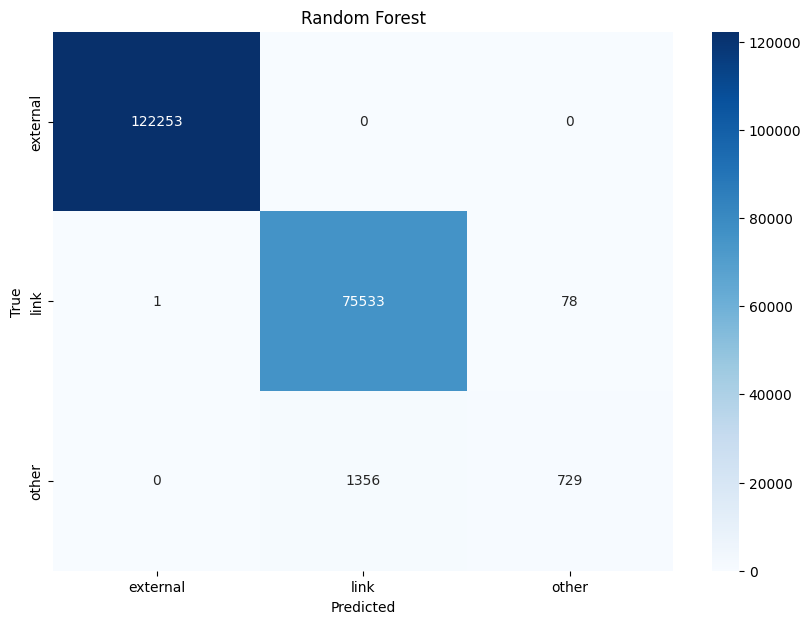

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)

# Evaluation
rf_acc = accuracy_score(y_test, y_pred_rf)
rf_report = classification_report(y_test, y_pred_rf)
rf_cm = confusion_matrix(y_test, y_pred_rf)

print("---- Random Forest ----")
print("Accuracy:", rf_acc)
print("Classification Report:\n", rf_report)
plot_confusion_matrix(rf_cm, "Random Forest", label_encoders['type'].classes_)


Its overall accuracy was very high, indicating that on average, the model correctly predicted the class labels for about 99% of the test samples. While accuracy is useful, sometimes it may not capture class imbalances well. Precision is also high, which shows good performance across the classes in terms of correctly identifying positive samples. In summary, although the Random Forest model shows high accuracy with good performance for most of the classes, the class imbalance of Class 2 would most probably further improve the overall model performance.

In [ ]:
print("X_test shape:", X_test.shape)  # Should be (199950, 3)
print("y_pred_rf shape:", y_pred_rf.shape)  # Should be (199950,)


X_test shape: (199950, 3)
y_pred_rf shape: (199950,)


# training the XGBoost algorithm
- a highly efficient and popular boosting algorithm for classification tasks.

---- XGBoost ----
Accuracy: 0.9885671417854464
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    122253
           1       0.98      0.99      0.99     75612
           2       0.62      0.18      0.28      2085

    accuracy                           0.99    199950
   macro avg       0.86      0.72      0.75    199950
weighted avg       0.99      0.99      0.99    199950



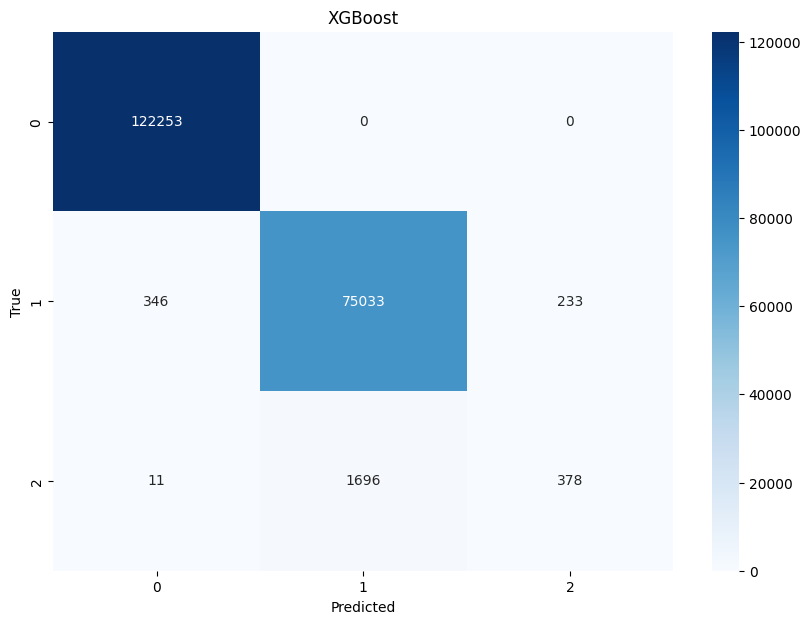

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Train XGBoost
xgb_model = XGBClassifier(eval_metric='mlogloss', random_state=42)  # Remove use_label_encoder
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluation
xgb_acc = accuracy_score(y_test, y_pred_xgb)
xgb_report = classification_report(y_test, y_pred_xgb, zero_division=1)
xgb_cm = confusion_matrix(y_test, y_pred_xgb)

print("---- XGBoost ----")
print("Accuracy:", xgb_acc)
print("Classification Report:\n", xgb_report)

# Ensure class names are properly handled for plotting
class_names = sorted(y_test.unique())
plot_confusion_matrix(xgb_cm, "XGBoost", class_names)


The accuracy of the XGBoost model is 98.86% , indicating a very high level of overall performance. The model is rightly predicting around 99% of the total test data points. The model performs very well for the big classes, namely Class 0 and Class 1, for which both precision and recall are very high. However, Class 2 receives a significant drop in recall-the model is inefficient at correctly identifying instances from Class 2.XGBoost works really well for most classes, especially the dominant classes of Class 0 and Class 1, with near perfect classification metrics.

In [ ]:
print("X_test shape:", X_test.shape)  # Should be (199950, 3)
print("y_pred_rf shape:", y_pred_xgb.shape)  # Should be (199950,)

X_test shape: (199950, 3)
y_pred_rf shape: (199950,)


# trainign the sgd classifier
This is a linear classifier that uses Stochastic Gradient Descent to fit the model.
It's efficient for large datasets and supports various loss functions, such as 'hinge' for linear SVMs (Support Vector Machines).

---- Stochastic Gradient Descent (SVM equivalent) ----
Accuracy: 0.9695973993498375
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98    122253
           1       0.97      0.95      0.96     75612
           2       1.00      0.00      0.00      2085

    accuracy                           0.97    199950
   macro avg       0.98      0.65      0.65    199950
weighted avg       0.97      0.97      0.96    199950



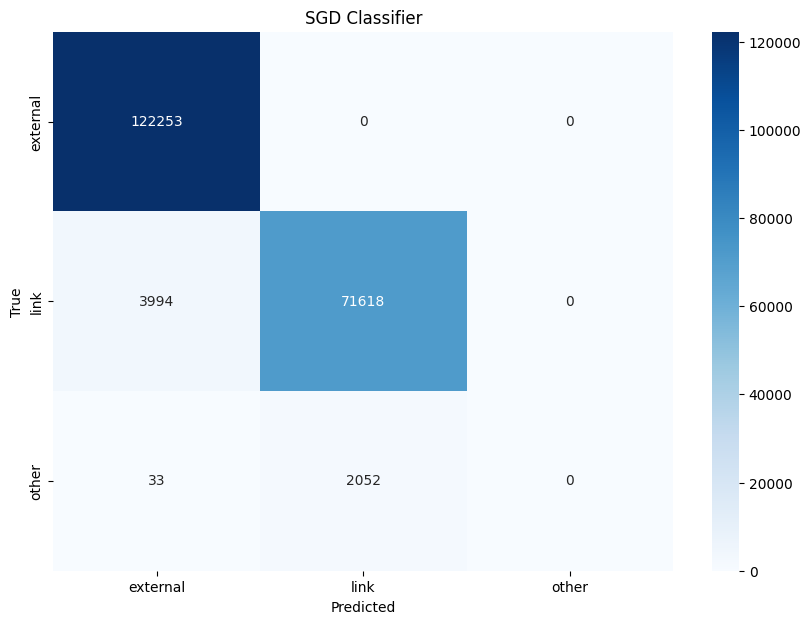

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train SGDClassifier with more iterations and class weighting
sgd_model = SGDClassifier(loss='hinge', random_state=42, max_iter=5000, class_weight='balanced')
sgd_model.fit(X_train_scaled, y_train)

# Predictions
y_pred_sgd = sgd_model.predict(X_test_scaled)

# Evaluation
sgd_acc = accuracy_score(y_test, y_pred_sgd)
sgd_report = classification_report(y_test, y_pred_sgd, zero_division=1)  # Avoid precision/recall undefined errors
sgd_cm = confusion_matrix(y_test, y_pred_sgd)

print("---- Stochastic Gradient Descent (SVM equivalent) ----")
print("Accuracy:", sgd_acc)
print("Classification Report:\n", sgd_report)

# Plot confusion matrix
plot_confusion_matrix(sgd_cm, "SGD Classifier", label_encoders['type'].classes_)


The high value of precision says that the overall model is performing good since it correctly classified the instances in the test set.
While the model does well in terms of accuracy and the classification of the majority class.

In [ ]:
print("X_test shape:", X_test.shape)  # Should be (199950, 3)
print("y_pred_rf shape:", y_pred_sgd.shape)

X_test shape: (199950, 3)
y_pred_rf shape: (199950,)


# Train Neural Network (MLP)
here , we used smote  to Balance the Dataset

---- Neural Network (MLP) ----
Accuracy: 0.7281370342585647
Classification Report:
               precision    recall  f1-score   support

           0       0.79      1.00      0.88    122253
           1       0.97      0.30      0.46     75612
           2       0.03      0.32      0.05      2085

    accuracy                           0.73    199950
   macro avg       0.60      0.54      0.47    199950
weighted avg       0.85      0.73      0.72    199950



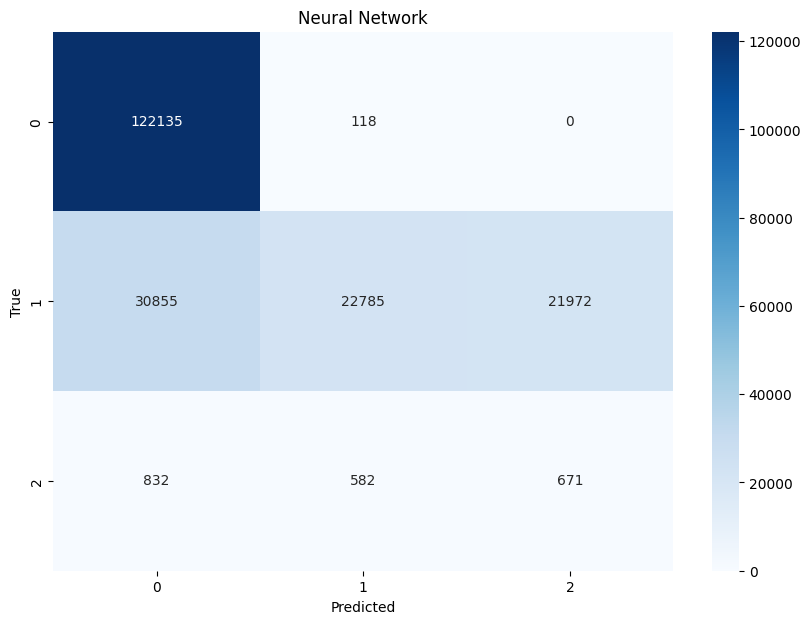

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.neural_network import MLPClassifier

# Applying SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train Neural Network (MLP)
mlp_model = MLPClassifier(hidden_layer_sizes=(50,), max_iter=200, random_state=42, early_stopping=True, n_iter_no_change=10)
mlp_model.fit(X_train_resampled, y_train_resampled)

# Predictions
y_pred_mlp = mlp_model.predict(X_test)

# Evaluation
mlp_acc = accuracy_score(y_test, y_pred_mlp)
mlp_report = classification_report(y_test, y_pred_mlp, zero_division=0)  # Added zero_division=0
mlp_cm = confusion_matrix(y_test, y_pred_mlp)

print("---- Neural Network (MLP) ----")
print("Accuracy:", mlp_acc)
print("Classification Report:\n", mlp_report)
plot_confusion_matrix(mlp_cm, "Neural Network", label_encoders['type'].classes_)


Accuracy of the Neural Network (MLP) model is 72.81%. This means that roughly 73% of the test samples were classified correctly by the model. The macro average gives the unweighted mean performance across all classes. The values are relatively low because of poor performance on class 2. Since the model performs well on the majority class, class 0, with a high recall of 1.00, it suggests that almost all instances of class 0 were correctly identified by the model, capturing the pattern of the dominant class effectively.

In [ ]:
print("X_test shape:", X_test.shape)  # Should be (199950, 3)
print("y_pred_rf shape:", y_pred_mlp.shape)

X_test shape: (199950, 3)
y_pred_rf shape: (199950,)


# Comparing model performances and evaluating multiple machine learning models based on key classification metrics and visualizing their performance.


Model Performance Metrics:

                     Accuracy  F1 Score  Precision    Recall
Logistic Regression  0.763676  0.816383   0.973740  0.763676
Random Forest        0.992823  0.991269   0.992318  0.992823
XGBoost              0.988567  0.985958   0.985885  0.988567
SGD Classifier       0.969597  0.964350   0.969969  0.969597
Neural Network       0.728137  0.715441   0.852659  0.728137


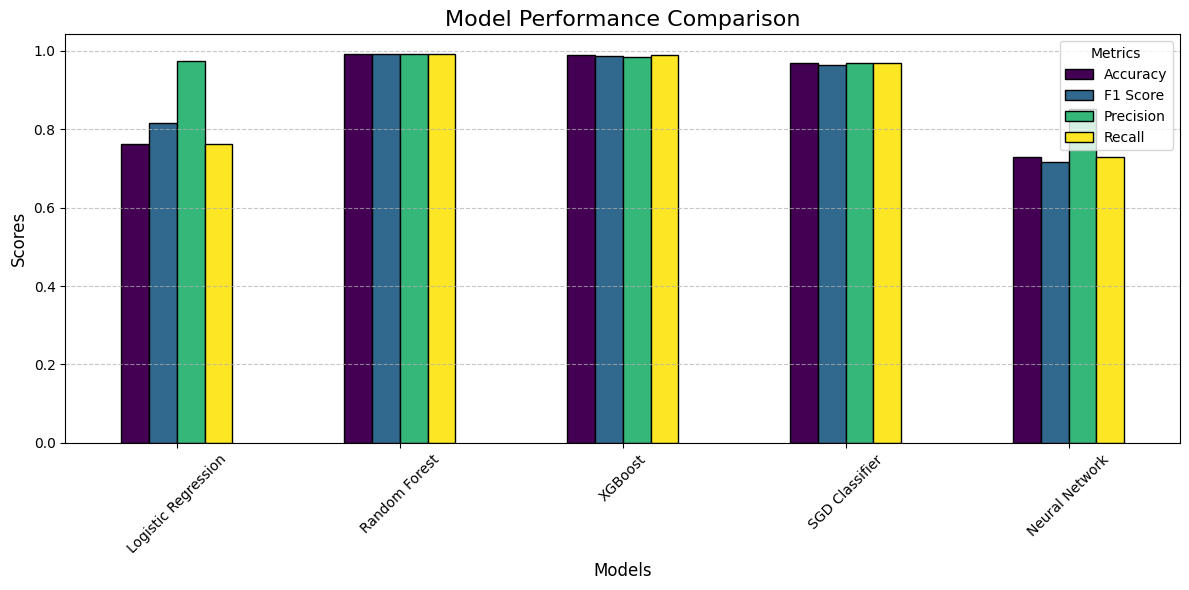


Sorted Model Performance by F1 Score:

                     Accuracy  F1 Score  Precision    Recall
Random Forest        0.992823  0.991269   0.992318  0.992823
XGBoost              0.988567  0.985958   0.985885  0.988567
SGD Classifier       0.969597  0.964350   0.969969  0.969597
Logistic Regression  0.763676  0.816383   0.973740  0.763676
Neural Network       0.728137  0.715441   0.852659  0.728137


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import pandas as pd
import matplotlib.pyplot as plt

def evaluate_model(y_test, y_pred, model_name):
    # Use an appropriate average for multiclass classification
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=1)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=1)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=1)
    return accuracy, f1, precision, recall

# Dictionary to store results
results = {}

# Replace these placeholders with your actual model predictions
model_predictions = {
    'Logistic Regression': y_pred_logistic,
    'Random Forest': y_pred_rf,
    'XGBoost': y_pred_xgb,
    'SGD Classifier': y_pred_sgd,
    'Neural Network': y_pred_mlp
}

# Evaluate each model and store the metrics
for model_name, y_pred in model_predictions.items():
    accuracy, f1, precision, recall = evaluate_model(y_test, y_pred, model_name)
    results[model_name] = [accuracy, f1, precision, recall]

# Convert results to a DataFrame for better visualization
results_df = pd.DataFrame(results, index=['Accuracy', 'F1 Score', 'Precision', 'Recall']).T
print("\nModel Performance Metrics:\n")
print(results_df)

# Function to plot model performance metrics
def plot_metrics(results_df):
    metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
    results_df[metrics].plot(kind='bar', figsize=(12, 6), colormap='viridis', edgecolor='black')
    plt.title('Model Performance Comparison', fontsize=16)
    plt.ylabel('Scores', fontsize=12)
    plt.xlabel('Models', fontsize=12)
    plt.xticks(rotation=45, fontsize=10)
    plt.legend(title='Metrics', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Plot the performance metrics
plot_metrics(results_df)

# Display sorted results for F1 Score
print("\nSorted Model Performance by F1 Score:\n")
print(results_df.sort_values(by='F1 Score', ascending=False))


-Random Forest is the best-performing model with an outstanding accuracy of 99.28%. It also achieves near-perfect precision, recall, and F1 score, making it the most reliable for this classification task.

-2nd, XGBoost runs with an excellent performance, too, with values very similar to the Random Forest. The slight drop in performance compared to Random Forest makes it the second choice.

-The SGD classifier also performs very well but lags a little behind Random Forest and XGBoost in recall; hence, it may miss some of the true positives.

-Neural Network - by far the worst performing, with significantly reduced accuracy, F1 score, and recall. This may require further tuning or a different approach; in this instance, though, it was outperformed by all the other models.

-Random Forest would be an ideal model for the best performance, considering its accuracy and excellent balance between precision and recall.
XGBoost can be considered a good alternative, mainly if one wants to experiment with gradient boosting algorithms-maybe other tasks will yield even better results.

# Hyperpamarater Tuning
GridSearchCV and RandomizedSearchCV for logistic regression, SGD, and MLP models.

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

In [ ]:
# Scale features
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SMOTE for balancing classes (only on training data)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)


In [ ]:
# Function to plot confusion matrix
def plot_confusion_matrix(cm, title, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

In [ ]:
# Logistic Regression with liblinear solver (without n_jobs)
logistic_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear']  # liblinear does not support parallelization
}
logistic_model = LogisticRegression(max_iter=500, class_weight="balanced", random_state=42)
logistic_grid = GridSearchCV(logistic_model, logistic_params, cv=5, verbose=1)
logistic_grid.fit(X_train_resampled, y_train_resampled)

# Evaluation
best_logistic_model = logistic_grid.best_estimator_
y_pred_logistic = best_logistic_model.predict(X_test_scaled)
logistic_acc = accuracy_score(y_test, y_pred_logistic)
logistic_report = classification_report(y_test, y_pred_logistic)
print("---- Logistic Regression (Tuned) ----")
print("Best Params:", logistic_grid.best_params_)
print("Accuracy:", logistic_acc)
print("Classification Report:\n", logistic_report)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
---- Logistic Regression (Tuned) ----
Best Params: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.8223205801450363
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    122253
           1       0.98      0.54      0.70     75612
           2       0.03      0.50      0.06      2085

    accuracy                           0.82    199950
   macro avg       0.66      0.68      0.58    199950
weighted avg       0.97      0.82      0.87    199950



The tuned Logistic regression significantly improves in accuracy, increasing from 76.3% to 82.2%. This improvement indicates that hyperparameter tuning helps the model converge better and perform more accurately.

The line multiprocessing.set_start_method('spawn', force=True) ensures that the safer spawn method is used for creating new processes. This avoids issues with fork that may cause problems with the loky backend.

Fitting 5 folds for each of 1 candidates, totalling 5 fits
---- Neural Network (MLP) (Tuned) ----
Best Params: {'max_iter': 200, 'learning_rate_init': 0.001, 'hidden_layer_sizes': (50,)}
Accuracy: 0.8317929482370593
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00    122253
           1       0.99      0.56      0.72     75612
           2       0.05      0.85      0.10      2085

    accuracy                           0.83    199950
   macro avg       0.68      0.80      0.60    199950
weighted avg       0.98      0.83      0.88    199950



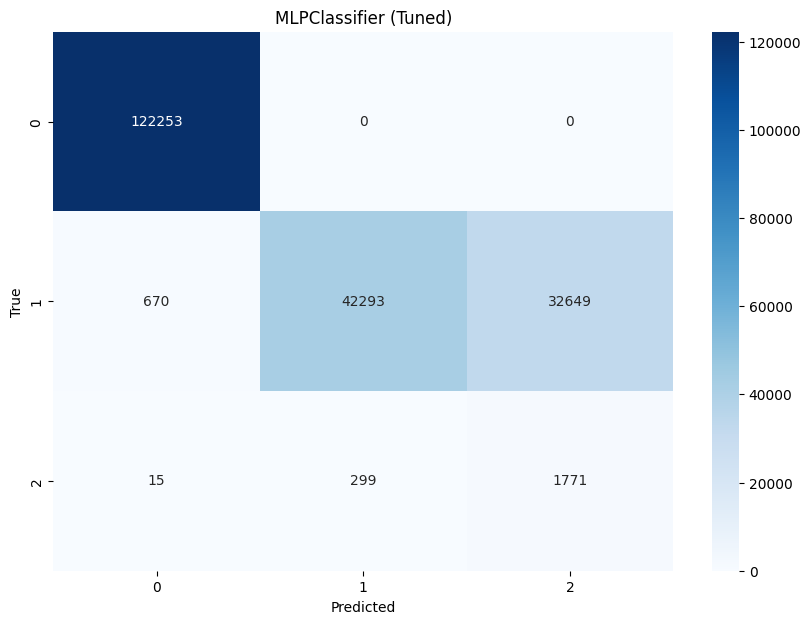

In [ ]:
import warnings
from sklearn.model_selection import RandomizedSearchCV
from joblib import parallel_backend

# Suppress the DeprecationWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)

# Reduced parameter grid for faster tuning
mlp_params = {
    'hidden_layer_sizes': [(50,)],  # Simpler grid with one hidden layer of 50 units
    'learning_rate_init': [0.001],
    'max_iter': [200]
}

# MLP model with early stopping
mlp_model = MLPClassifier(random_state=42, early_stopping=True, n_iter_no_change=10)

# Use RandomizedSearchCV for faster tuning with n_iter=1
mlp_random = RandomizedSearchCV(mlp_model, mlp_params, n_iter=1, cv=5, n_jobs=1, verbose=1)

# Using parallel_backend to ensure multiprocessing is used
with parallel_backend('multiprocessing'):
    mlp_random.fit(X_train_resampled, y_train_resampled)

# Best MLP model
best_mlp_model = mlp_random.best_estimator_

# Prediction on test set
y_pred_mlp = best_mlp_model.predict(X_test_scaled)

# Evaluation
mlp_acc = accuracy_score(y_test, y_pred_mlp)
mlp_report = classification_report(y_test, y_pred_mlp)
print("---- Neural Network (MLP) (Tuned) ----")
print("Best Params:", mlp_random.best_params_)
print("Accuracy:", mlp_acc)
print("Classification Report:\n", mlp_report)

# Confusion matrix
mlp_cm = confusion_matrix(y_test, y_pred_mlp)

# Function to plot confusion matrix (assuming the function is defined elsewhere)
plot_confusion_matrix(mlp_cm, "MLPClassifier (Tuned)", label_encoders['type'].classes_)


The tuned Neural Network (MLP) significantly improves in accuracy, increasing from 72.81% to 83.18%. This improvement indicates that hyperparameter tuning  helps the model converge better and perform more accurately.

# Data Preprocessing and K-Means Clustering

In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans

# Encode categorical variables
le_prev = LabelEncoder()
le_curr = LabelEncoder()
le_type = LabelEncoder()
df['prev'] = le_prev.fit_transform(df['prev'])
df['curr'] = le_curr.fit_transform(df['curr'])
df['type'] = le_type.fit_transform(df['type'])

# Normalize numerical data
scaler = StandardScaler()
df[['n']] = scaler.fit_transform(df[['n']])

# Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(df[['prev', 'curr', 'type', 'n']])

# Analyze clusters
print(df.groupby('cluster').mean())


                  prev           curr      type         n
cluster                                                  
0        168558.199657  103100.830854  0.262538  0.100925
1        150186.245503  264031.348666  0.392841  0.046717
2        153203.059663  579705.108828  0.340225 -0.014269
3         47753.816918   76361.483490  1.021446 -0.270402
4        151088.158282  421715.232800  0.359532 -0.026187


The results of the clustering feature show that 'prev', 'curr', 'type', and 'n' have been separated into 5 clusters based on their similarities. It can be observed that the average value variation in these clusters suggests different data point types or behaviors that could be represented by the variables.
Cluster 3 seems like an anomaly, with values much lower across most of these features.
The feature values for Clusters 0, 1, 2, and 4 all appear very similar; however, each cluster has certain characteristics that are unique to it, especially regarding the three 'prev', 'curr', and 'type' features.

# 3D PCA Visualization of K-Means Clustering

PCA is used to project the data into fewer dimensions (3 in this case) while retaining as much variance as possible. It helps visualize high-dimensional data in a 3D space.


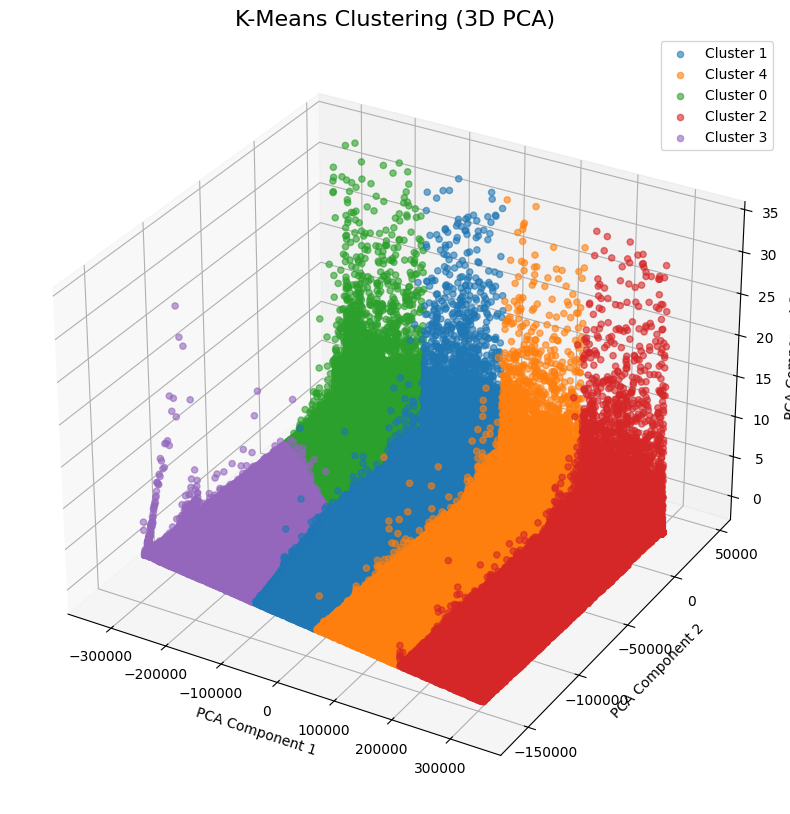

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

# Reduce dimensions to 3D
pca_3d = PCA(n_components=3)
df_pca_3d = pca_3d.fit_transform(df[['prev', 'curr', 'type', 'n']])

# Add PCA results to the dataframe
df['pca_3d_1'] = df_pca_3d[:, 0]
df['pca_3d_2'] = df_pca_3d[:, 1]
df['pca_3d_3'] = df_pca_3d[:, 2]

# 3D Scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

for cluster in df['cluster'].unique():
    cluster_data = df[df['cluster'] == cluster]
    ax.scatter(cluster_data['pca_3d_1'], cluster_data['pca_3d_2'], cluster_data['pca_3d_3'], label=f'Cluster {cluster}', alpha=0.6)

ax.set_title('K-Means Clustering (3D PCA)', fontsize=16)
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
ax.legend()
plt.show()


# Network Analysis with Centrality Measures
#extra study

nx.degree_centrality(subgraph): Calculates the degree centrality for each node in the subgraph. Degree centrality measures how many direct connections (edges) a node has. A higher value means the node is connected to more other nodes.

nx.pagerank(subgraph, alpha=0.85): Calculates the PageRank of each node in the subgraph. PageRank is an algorithm that ranks nodes based on the number and quality of links (edges) that point to them, with the alpha parameter controlling the damping factor (probability of jumping to a random node).

nx.betweenness_centrality(subgraph): Calculates betweenness centrality for each node. Betweenness centrality measures how often a node acts as a bridge along the shortest path between two other nodes. A higher value indicates that a node is an important connector in the network.


In [ ]:
import networkx as nx
import pandas as pd
import numpy as np

df2 = df2.dropna(subset=['prev', 'curr', 'n'])

# Initialize directed graph
G = nx.DiGraph()

# Add edges with weights
for _, row in df_chunk.iterrows():
    if pd.notna(row['prev']) and pd.notna(row['curr']):
        G.add_edge(row['prev'], row['curr'], weight=row['n'])

# Degree Centrality (only calculate for the top 1000 nodes to reduce memory usage)
top_nodes = list(G.nodes)[:20000]  # You can adjust the number of nodes being processed
subgraph = G.subgraph(top_nodes)
degree_centrality = nx.degree_centrality(subgraph)
top_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 Pages by Degree Centrality:", top_degree)

# PageRank (calculate only for the top 1000 nodes)
pagerank = nx.pagerank(subgraph, alpha=0.85)
top_pagerank = sorted(pagerank.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 Pages by PageRank:", top_pagerank)

# Betweenness Centrality (calculate for a subgraph of 1000 nodes to reduce time and memory usage)
betweenness = nx.betweenness_centrality(subgraph)
top_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 Pages by Betweenness Centrality:", top_betweenness)

# Clustering Coefficient (calculate for the subgraph)
clustering = nx.clustering(subgraph.to_undirected())  # Using undirected clustering coefficient
average_clustering = sum(clustering.values()) / len(clustering) if len(clustering) > 0 else 0
print("Average Clustering Coefficient:", average_clustering)


Top 10 Pages by Degree Centrality: [('other-empty', 0.9558477923896195), ('other-search', 0.44197209860493025), ('other-internal', 0.04205210260513025), ('Main_Page', 0.009250462523126156), ('other-other', 0.009150457522876144), ('other-external', 0.008000400020001), ('List_of_American_films_of_2024', 0.002200110005500275), ('Joker:_Folie_à_Deux', 0.0019000950047502374), ('2024_United_States_presidential_election', 0.0019000950047502374), ('Donald_Trump', 0.0019000950047502374)]
Top 10 Pages by PageRank: [('Margaret_Qualley', 0.0005572902476751004), ('Emma_Corrin', 0.0005511902126851689), ('Bill_Skarsgård', 0.0004945196524833312), ('Callum_Turner', 0.000491018647313788), ('Dakota_Johnson', 0.00048795696840526445), ('Aaron_Taylor-Johnson', 0.00048625260217725923), ('N.W.A', 0.00048206414299662283), ('2024_United_States_presidential_election_in_Pennsylvania', 0.0004713169738244281), ('Wayans_family', 0.0004623311771537775), ('Citadel_(TV_series)', 0.0004616066842045845)]
Top 10 Pages by 

By using Degree Centrality, the most well-connected node considering direct links is 'other-empty'.
PageRank identifies 'Margaret_Qualley' as the most important node based on the quality of its incoming links.

Betweenness Centrality indicates '2024_in_film' as the important connector node.

The overall low clustering coefficient reflects that the network has a low clustering level, meaning the nodes are somewhat sparsely interconnected in forming triangles.

These different centrality measures provide insight into the structure and relative importance of nodes within a network, enabling the identification of key pages and their relationships in the data.

# Generating a basic visualization of a subgraph of the Wikipedia clickstream network, focusing on the top 5000 nodes.

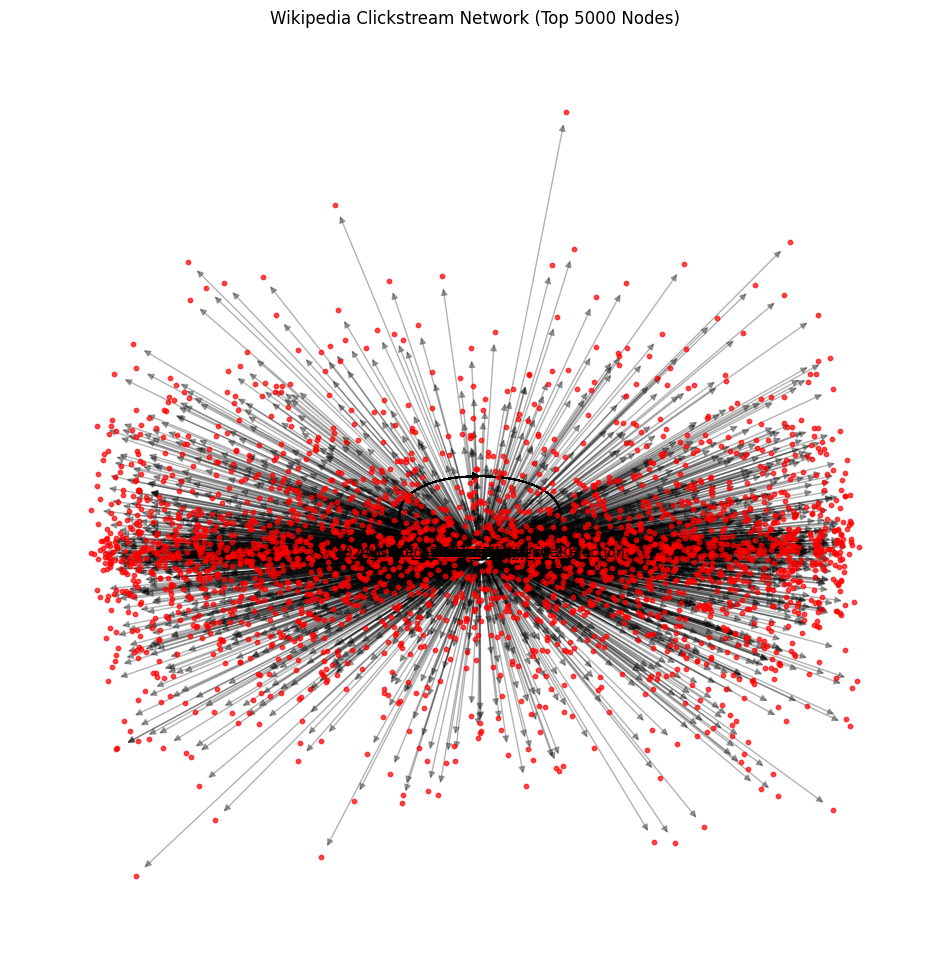

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Assuming 'G' is the pre-loaded graph (replace with your actual graph if needed)

top_nodes = list(G.nodes)[:5000]  # You can adjust the number of nodes being processed
subgraph = G.subgraph(top_nodes)

# Basic visualization (using a more efficient layout)
plt.figure(figsize=(12, 12))

# Use a more efficient layout (spectral_layout for large graphs)
pos = nx.spectral_layout(subgraph)  # You can change to other layouts like 'shell_layout'

# Draw nodes
nx.draw_networkx_nodes(subgraph, pos, node_size=10, node_color='red', alpha=0.7)

# Draw edges
nx.draw_networkx_edges(subgraph, pos, alpha=0.3)  # Reduced edge opacity for clarity

# Optionally add labels for the top nodes by degree or centrality (to reduce clutter, you can limit this)
top_degree = sorted(nx.degree_centrality(subgraph).items(), key=lambda x: x[1], reverse=True)[:10]
labels = {node: node for node, _ in top_degree}  # Only label the top 10 nodes
nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=10)

plt.title("Wikipedia Clickstream Network (Top 5000 Nodes)")
plt.axis('off')  # Turn off the axis
plt.show()


The resulting plot shows us display the top 5000 nodes of the Wikipedia clickstream network, arranged using the spectral layout. Key nodes (based on degree centrality) is labeled, and the graph shows the interconnections between nodes, helping visualize the structure of the network.

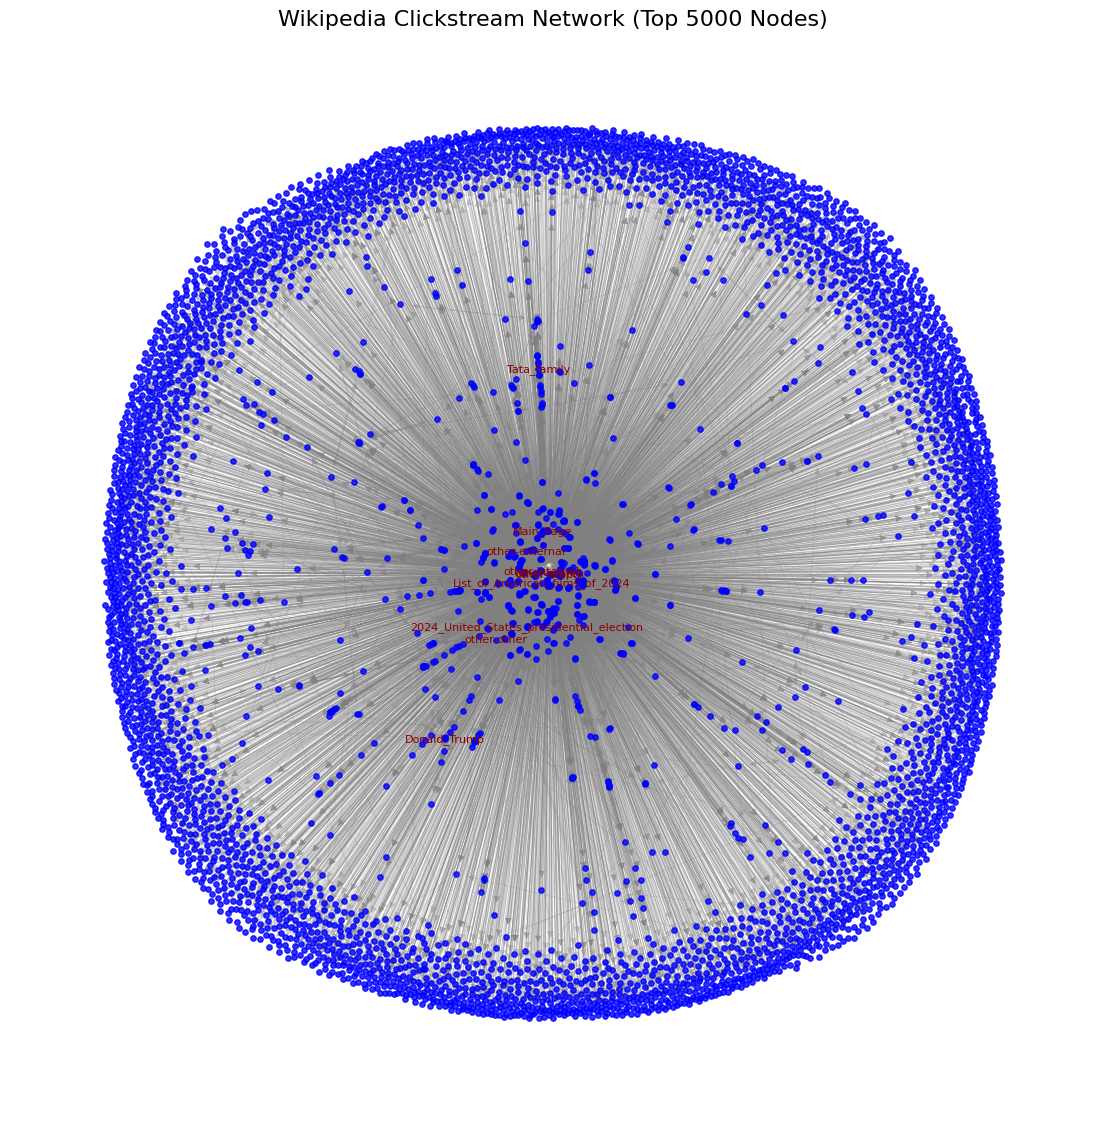

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Assuming 'G' is the pre-loaded graph (replace with your actual graph if needed)

# Limit the graph size by selecting a subgraph with fewer nodes
top_nodes = list(G.nodes)[:5000]  # Adjust the number of nodes as needed for clarity
subgraph = G.subgraph(top_nodes)

# Larger figure size for better visualization
plt.figure(figsize=(14, 14))

# Use a spring layout for better clarity in large graphs
pos = nx.spring_layout(subgraph, k=0.1)  # 'k' controls the spacing between nodes

# Draw nodes
nx.draw_networkx_nodes(
    subgraph, pos,
    node_size=15,  # Increase size for better visibility
    node_color='blue', alpha=0.8
)

# Draw edges
nx.draw_networkx_edges(
    subgraph, pos,
    edge_color='gray', alpha=0.3, width=0.5  # Adjust width and opacity for clarity
)

# Optionally, label the top 10 nodes by degree centrality
top_degree = sorted(nx.degree_centrality(subgraph).items(), key=lambda x: x[1], reverse=True)[:10]
labels = {node: node for node, _ in top_degree}
nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=8, font_color='darkred')

# Add a title and turn off axis
plt.title("Wikipedia Clickstream Network (Top 5000 Nodes)", fontsize=16)
plt.axis('off')
plt.show()


Visualization of the top 5000 nodes in your graph G using a spring layout for better clarity.
The resulting plot shows us  a network visualization of the Wikipedia clickstream consisting of 5000 nodes, arranged using the spring layout.


In [ ]:
top_nodes = list(G.nodes)[:10000]  # You can adjust the number of nodes being processed
subgraph = G.subgraph(top_nodes)

# Check if the subgraph is connected
print("Is the subgraph connected?", nx.is_connected(subgraph.to_undirected()))

# Calculate Degree Centrality, PageRank, and Betweenness Centrality for the subgraph
degree_centrality = nx.degree_centrality(subgraph)
pagerank = nx.pagerank(subgraph, alpha=0.85)

# Use unweighted version for betweenness centrality if weights are causing issues
betweenness_centrality = nx.betweenness_centrality(subgraph, weight=None)

df_chunk.loc[:, 'degree_centrality'] = df_chunk['prev'].map(degree_centrality)
df_chunk.loc[:, 'pagerank'] = df_chunk['prev'].map(pagerank)
df_chunk.loc[:, 'betweenness_centrality'] = df_chunk['prev'].map(betweenness_centrality)

# Drop NaN values if any pages don’t map (nodes not in the subgraph)
df_chunk = df_chunk.dropna(subset=['degree_centrality', 'pagerank', 'betweenness_centrality'])

# Now df_chunk contains the additional network metrics for the top 10000 nodes
print(df_chunk.head())

Is the subgraph connected? True


The graph is connected, and most nodes in the subgraph have high degree centrality, indicating that they are well-connected within the network. However, the PageRank values are low, meaning the nodes are not highly important in terms of network influence, and betweenness centrality is minimal, suggesting the subgraph might not have significant intermediary nodes. These findings can be used to understand some of the structural properties of the graph and where the most influential or important nodes might be in terms of centrality. Finally, the degree_centrality value is 0.982298 for all rows in the sample output, indicating that all of the nodes have a relatively high number of connections in the subgraph with respect to the total number of nodes. This seems to indicate that these nodes are some of the more connected nodes within the network. The pagerank value is very low-0.000064-for all the nodes in the sample. This is typical for nodes that are not highly influential, meaning not many important incoming connections from other nodes.
The betweenness_centrality value is 0.0 for all nodes, showing that none of these nodes act as significant bridges or even intermediaries between other nodes in this subgraph.
This implies that the subgraph is more decentralized, or the nodes are not placed at strategic positions with respect to connectivity.

